# Compas Analysis

La méthodologie de Propublica est décrite [ici](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/).

L'objectif est simplement de suivre le processus d'extraction ds données pour ensuite en déduire des estimations par intervalle de confiance de 
- l'impact disproportionné sur les vraies données Y, 
- ce même impact pour le score de récidive High vs. low issu de compas
- la direction du biais: discirmination selon Propublica

## Lire les données

Sélection des champs: sévérité de la charge, nombre d'a priori, démographie,âge, genre, score compas, et récidive ou non dnas les deux ans.

In [1]:
library(dplyr)
library(ggplot2)
raw_data <- read.csv("./compas-scores-two-years.csv")
nrow(raw_data)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



[1] 7214

In [2]:
summary(raw_data)

       id                       name              first            last     
 Min.   :    1   anthony smith    :   3   michael    : 149   williams:  83  
 1st Qu.: 2735   angel santiago   :   2   christopher: 109   johnson :  76  
 Median : 5510   anthony gonzalez :   2   james      :  84   brown   :  68  
 Mean   : 5501   anthony louis    :   2   anthony    :  83   smith   :  65  
 3rd Qu.: 8246   brandon whitfield:   2   robert     :  76   jones   :  57  
 Max.   :11001   carlos vasquez   :   2   john       :  74   davis   :  46  
                 (Other)          :7201   (Other)    :6639   (Other) :6819  
 compas_screening_date     sex               dob            age       
 2013-02-20:  32       Female:1395   1987-02-04:   5   Min.   :18.00  
 2013-03-20:  32       Male  :5819   1987-12-21:   5   1st Qu.:25.00  
 2013-02-07:  31                     1989-04-27:   5   Median :31.00  
 2013-04-20:  30                     1989-08-31:   5   Mean   :34.82  
 2013-01-03:  29             

Elimination de certaines lignes: 
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [3]:
df <- dplyr::select(raw_data, age, c_charge_degree, race, age_cat, score_text, sex, priors_count, 
                    days_b_screening_arrest, decile_score, is_recid, two_year_recid, c_jail_in, c_jail_out) %>% 
        filter(days_b_screening_arrest <= 30) %>%
        filter(days_b_screening_arrest >= -30) %>%
        filter(is_recid != -1) %>%
        filter(c_charge_degree != "O") %>%
        filter(score_text != 'N/A')
nrow(df)

[1] 6172

In [4]:
summary(df)

      age        c_charge_degree               race                 age_cat    
 Min.   :18.00   F:3970          African-American:3175   25 - 45        :3532  
 1st Qu.:25.00   M:2202          Asian           :  31   Greater than 45:1293  
 Median :31.00                   Caucasian       :2103   Less than 25   :1347  
 Mean   :34.53                   Hispanic        : 509                         
 3rd Qu.:42.00                   Native American :  11                         
 Max.   :96.00                   Other           : 343                         
                                                                               
  score_text       sex        priors_count    days_b_screening_arrest
 High  :1144   Female:1175   Min.   : 0.000   Min.   :-30.00         
 Low   :3421   Male  :4997   1st Qu.: 0.000   1st Qu.: -1.00         
 Medium:1607                 Median : 1.000   Median : -1.00         
                             Mean   : 3.246   Mean   : -1.74         
          

Corrélation entre la durée d'emprisonnement et le score comaps

In [5]:
df$length_of_stay <- as.numeric(as.Date(df$c_jail_out) - as.Date(df$c_jail_in))
cor(df$length_of_stay, df$decile_score)

[1] 0.2073297

Données démograpiques

In [6]:
summary(df$age_cat)

25 - 45 Greater than 45    Less than 25 
           3532            1293            1347

In [7]:
summary(df$race)

African-American            Asian        Caucasian         Hispanic 
            3175               31             2103              509 
 Native American            Other 
              11              343

In [8]:
round(summary(df$race)/6172*100,2)

African-American            Asian        Caucasian         Hispanic 
           51.44             0.50            34.07             8.25 
 Native American            Other 
            0.18             5.56

In [9]:
summary(df$score_text)

High    Low Medium 
  1144   3421   1607

In [10]:
xtabs(~ sex + race, data=df)

        race
sex      African-American Asian Caucasian Hispanic Native American Other
  Female              549     2       482       82               2    58
  Male               2626    29      1621      427               9   285

In [11]:
summary(df$sex)

Female   Male 
  1175   4997

In [12]:
round(summary(df$sex)/6172*100,2)

Female   Male 
 19.04  80.96

In [13]:
nrow(filter(df, two_year_recid == 1))

[1] 2809

In [14]:
nrow(filter(df, two_year_recid == 1)) / nrow(df) * 100

[1] 45.51199

Distribution (déciles) des scores en fonction de l'origine ethnique.


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



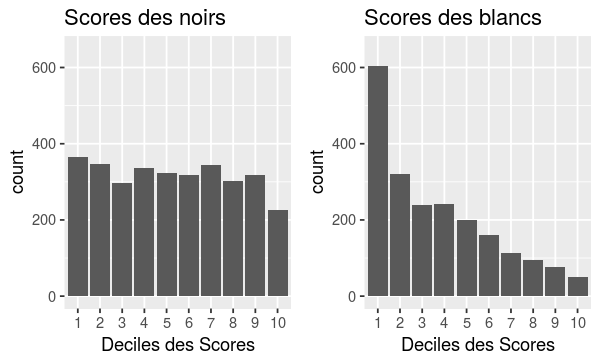

In [15]:
library(grid)
library(gridExtra)
options(repr.plot.width=5, repr.plot.height=3)
pblack <- ggplot(data=filter(df, race =="African-American"), aes(ordered(decile_score))) + 
          geom_bar() + xlab("Deciles des Scores") +
          ylim(0, 650) + ggtitle("Scores des noirs")
pwhite <- ggplot(data=filter(df, race =="Caucasian"), aes(ordered(decile_score))) + 
          geom_bar() + xlab("Deciles des Scores") +
          ylim(0, 650) + ggtitle("Scores des blancs")
grid.arrange(pblack, pwhite,  ncol = 2)

In [16]:
xtabs(~ decile_score + race, data=df)

            race
decile_score African-American Asian Caucasian Hispanic Native American Other
          1               365    15       605      159               0   142
          2               346     4       321       89               2    60
          3               298     5       238       73               1    32
          4               337     0       243       47               0    39
          5               323     1       200       39               0    19
          6               318     2       160       27               2    20
          7               343     1       113       28               2     9
          8               301     2        96       14               0     7
          9               317     0        77       17               2     7
          10              227     1        50       16               2     8

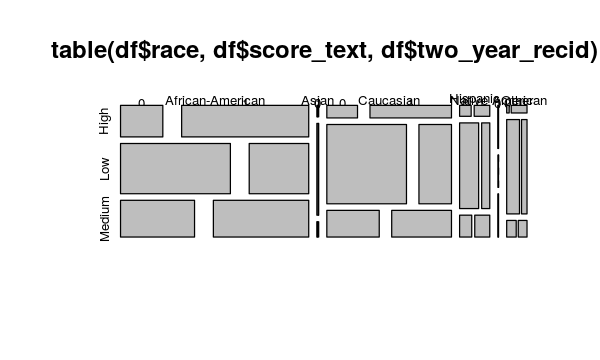

In [17]:
mosaicplot(table(df$race,df$score_text,df$two_year_recid))

## Estimations des impacts de disproportion
Plutôt que la stratégie de Propublica d'estimer un modèle logistique pour montrer que la cote des noires d'obtenir un score élevé est plus importante que celle des blancs en fonction de leur passé.

Extraction des données utiles.

In [18]:
df2=data.frame("OrigEth"=df$race,"Compas"=df$score_text, "Recidive"=df$two_year_recid==1)
summary(df2)

             OrigEth        Compas      Recidive      
 African-American:3175   High  :1144   Mode :logical  
 Asian           :  31   Low   :3421   FALSE:3363     
 Caucasian       :2103   Medium:1607   TRUE :2809     
 Hispanic        : 509                                
 Native American :  11                                
 Other           : 343                                

Se limiter aux deux origines: afro-américaine *vs.* caucasienne. Supprimer le score "Medium".

In [19]:
df3=df2[df2$OrigEth=='African-American'|df2$OrigEth=='Caucasian',]
df3$OrigEth=factor(df3$OrigEth)
df3=df3[df3$Compas!='Medium',]
df3$Compas=factor(df3$Compas)
summary(df3)

             OrigEth      Compas      Recidive      
 African-American:2191   High:1068   Mode :logical  
 Caucasian       :1630   Low :2753   FALSE:2144     
                                     TRUE :1677     

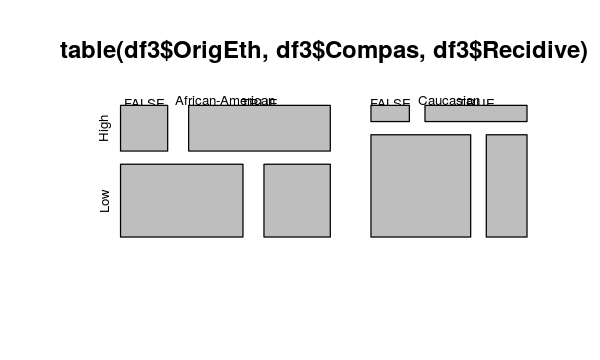

In [20]:
mosaicplot(table(df3$OrigEth,df3$Compas,df3$Recidive))

### Estimation des mesures de discrimination
Deux niveaux de mesures de discrimination sont considérées. Le premier: *discrimination assessment* ou DA est calculé sur les données d'apprentissage afin d'évaluer le biais discriminatoire déjà présent dans les données. Le deuxième mesure l'impact d'un modèle ou algorithme sur la discrimination: *discrimination impact assessment* ou DIA. 

Les deux mesures de discrimination de groupe sont basées sur ce qui est couramment appelé dans la littérature *disparate impact* (*DI*). Il est défini par le rapport de deux probabilités. 

*Notations*: 

- $Y$ est la variable cible ou à expliquer, ici la récidive 
- $\hat{Y}$ le score de récidive élevé ou faible ouprévision de la récidive
- $S$ est la variable sensible qui désigne le groupe sensible en principe protégé par la loi contre une possible discrtimination. Il s'agit ici de l'origine ethnique réduite à 2 modalités: caucasien ou afro américain. 

$$DI=\frac{P(Y=1|S=0)}{P(Y=1|S=1)}.$$

Cette quantité est estimée à partir des valeurs de la table de contingence croisant les variables $Y$ et $S$.
#### Fonction *disparate*
Une fonction R estime cette quantité et fournit de plus une estimation par intervalle de confiance (Besse et al. 2018) du *DI*. Cette  fonction a trois arguments:   
- une matrice $X$ de valeurs binaires $(0,1)$ dont la dernière colonne contient la décision $Y$ ou cible à analyser;
- l'indice $S$ de la variable de $X$ considérée comme sensible; 
- le risque de l'intervalle de confiance, par défaut 5%.

Elle renvoie les trois estimations $DI$ et $IC_g$, $IC_d$ bornes de l'intervalle de confiance.

In [22]:
source("disparate.R")
disparate

function (X, S, alpha = 0.05) 
{
    if (S > ncol(X)) 
        stop(paste("L'argument S doit être compris entre 1 et ", 
            ncol(X) - 1))
    n <- nrow(X)
    pi_1 <- sum(X[, S])/n
    pi_0 <- 1 - pi_1
    p_1 <- sum(X[, S] * X[, ncol(X)])/n
    p_0 <- sum((1 - X[, S]) * X[, ncol(X)])/n
    Tn <- p_0 * pi_1/(p_1 * pi_0)
    grad <- grad_h(c(p_0, p_1, pi_0, pi_1))
    Cov_4 <- diag(rep(0, 4)) + cbind(c(0, -p_0 * p_1, pi_1 * 
        p_0, -pi_1 * p_0), c(0, 0, -pi_0 * p_1, pi_0 * p_1), 
        c(0, 0, 0, -pi_0 * pi_1), c(0, 0, 0, 0))
    Cov_4 <- Cov_4 + t(Cov_4) + diag(c(p_0 * (1 - p_0), p_1 * 
        (1 - p_1), pi_0 * pi_1, pi_0 * pi_1))
    sigma <- sqrt((grad %*% Cov_4) %*% t(t(grad)))
    lower_lim <- Tn - (sigma * qnorm(1 - alpha/2, mean = 0, sd = 1))/sqrt(n)
    upper_lim <- Tn + (sigma * qnorm(1 - alpha/2, mean = 0, sd = 1))/sqrt(n)
    return(c(lower_lim, Tn, upper_lim))
}

#### *Discrimination assessment* (DA) des données d'apprentissage


In [23]:
summary(df3)

             OrigEth      Compas      Recidive      
 African-American:2191   High:1068   Mode :logical  
 Caucasian       :1630   Low :2753   FALSE:2144     
                                     TRUE :1677     

In [24]:
# Variable origine rendue entière: 0, 1
s= as.integer(df3$OrigEth)-1
# Variable cible ou décision (seuil de revenu) également entière: 0, 1
Ychap=as.integer(df3$Compas)-1
Y=1-as.integer(df3$Recidive)
coded_data=data.frame(s,Ychap,Y)

In [25]:
cbind(df3,coded_data)[1:20,]

,OrigEth,Compas,Recidive,s,Ychap,Y
2,African-American,Low,TRUE,0,1,0
3,African-American,Low,TRUE,0,1,0
7,Caucasian,Low,FALSE,1,1,1
8,Caucasian,Low,FALSE,1,1,1
10,Caucasian,Low,FALSE,1,1,1
11,African-American,Low,FALSE,0,1,1
12,Caucasian,Low,TRUE,1,1,0
13,African-American,Low,TRUE,0,1,0
15,African-American,High,FALSE,0,0,1
17,Caucasian,Low,TRUE,1,1,0


In [26]:
summary(coded_data)

       s              Ychap              Y         
 Min.   :0.0000   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :0.0000   Median :1.0000   Median :1.0000  
 Mean   :0.4266   Mean   :0.7205   Mean   :0.5611  
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :1.0000   Max.   :1.0000   Max.   :1.0000  

In [27]:
disparate(coded_data,1,alpha=0.05)

[1] 0.7187268 0.7607967 0.8028667

In [28]:
disparate(coded_data[,-3],1,alpha=0.05)

[1] 0.6843727 0.7116987 0.7390248

Taux d'erreur du score Compas pour prédire la récidive.

In [36]:
table(df3$Compas,df3$Recidive)

      
       FALSE TRUE
  High   272  796
  Low   1872  881

In [33]:
(272+881)/(272+881+796+1872)

[1] 0.3017535

Taux de faux positifs puis de faux négatifs

In [38]:
272/(272+1872); 881/(881+796)

[1] 0.1268657

[1] 0.5253429

Même chose selon l'origine.

In [34]:
table(df3$Compas,df3$Recidive,df3$OrigEth)

, ,  = African-American

      
       FALSE TRUE
  High   211  634
  Low    873  473

, ,  = Caucasian

      
       FALSE TRUE
  High    61  162
  Low    999  408


Taux d'erreur pour les noirs vs. taux d'erreur pour les blancs

In [43]:
(211+473)/(211+473+873+634); (61+408)/(61+408+999+162)

[1] 0.3121862

[1] 0.2877301

Taux de faux positifs pour les noirs à comparer avec le taux de faux positifs pour les blancs

In [40]:
211/(211+873);61/(61+999)

[1] 0.1946494

[1] 0.05754717

Taux de faux négatifs  pour les noirs à comparer avec le taux de faux négatifs pour les blancs

In [44]:
473/(473+634);408/(162+408)

[1] 0.4272809

[1] 0.7157895

Taux de faux positif pour les noirs: 

In [29]:
source("OverallAccuracyEquality.R")
OAE(coded_data,1,3,2,.05)

,inf,est_value,sup
TP,0.8264721,0.8545261,0.8825801
TN,1.7332774,2.0151226,2.2969679


In [30]:
source("ConditionalUseEquality.R")
CUAE(coded_data,1,3,2,.05)

,inf,est_value,sup
Y=0/f(X)=1,1.0793638,1.2118532,1.344343
Y=1/f(X)=0,0.6903557,0.9128528,1.135350
